# Desviación de una partícula cargada por un campo magnético dipolar

In [1]:
from numpy import *
from scipy import *
from scipy.integrate import *
from scipy.optimize import *
from pylab import *
from JSAnimation import IPython_display
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
#from mayavi.mlab import *
#from time import *
%matplotlib inline

El campo magnético producido por un dipolo en coordenadas rectangulares es:

$$\vec B (\vec r) = \frac{\mu_{0}}{4 \pi r^3} (3( \vec{m} \cdot \hat{r}) \hat{r} - \vec{m})$$

donde $\vec{m}$ es el momento del dipolar magnético. Por lo tanto si en el punto colocamos una brújula, ésta apuntará en la dirección de $\vec B$.

In [2]:
#la ecuación que nos indica la dirección del campo magnético en el punto producido por el dipolo
#en el plano yz
theta_0 = 0*(23./180.)*pi

def campo_dipolo_mag(r_vec, t):
    # mu indica hacia dónde está orientado el dipolo
    mu = [cos(theta_0), sin(theta_0)]
    #distancia de la partícula al dipolo
    r = sqrt((r_vec[0]**2) + (r_vec[1]**2) )
    #mu producto punto el vector en el que se encuentra la partícula
    mu_dot_r = (mu[0]*r_vec[0]) + (mu[1]*r_vec[1])
    #las ecuaciones en yz
    B_r = ( (3*mu_dot_r*r_vec[0])/(r**5) ) - ( (mu[0])/(r**3) )
    B_z = ( (3*mu_dot_r*r_vec[1])/(r**5) ) - ( (mu[1])/(r**3) )
    return B_r, B_z

#la función de arriba pero normalizada para que se aprecie la dirección del cámpo magnético en los planos, pero no su magnitud
#debido que al acercarse a 0 la magnitud se nace enorme
def campo_dipolo_mag_norm(r_vec,t):
    mu = [cos(theta_0), sin(theta_0)]
    r = sqrt(r_vec[0]**2 + r_vec[1]**2)
    mu_dot_r = (mu[0]*r_vec[0]) + (mu[1]*r_vec[1])
    B_y = ( (3*mu_dot_r*r_vec[0])/(r**2) ) - mu[0]
    B_z = ( (3*mu_dot_r*r_vec[1])/(r**2) ) - mu[1]
    
    b_y = B_y/( sqrt(B_y**2 + B_z**2))
    b_z = B_z/( sqrt(B_y**2 + B_z**2))
    return b_y,b_z

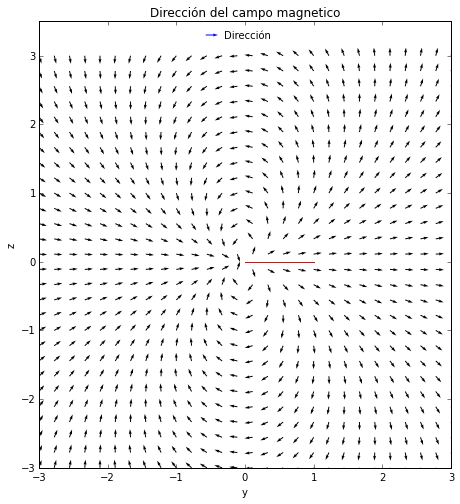

In [3]:
N_malla = 28
y = linspace(-3,3,N_malla)
z = linspace(-3,3,N_malla)
Y,Z = meshgrid(y,z)
b_y,b_z = campo_dipolo_mag_norm([Y,Z], 0)
figure(figsize=(8,8),dpi=80)
QP = quiver(Y,Z,b_y,b_z)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot([0, cos(theta_0)], [0, sin(theta_0)], 'r')

xlabel('y') 
ylabel('z')
axis([-3, 3, -3, 3.5])
title(u'Dirección del campo magnetico')
quiverkey(QP, -0.4, 3.3, 1.5, u'Dirección', labelpos='E',coordinates='data',color="blue")
show()

Aquí ponemos la ecuación del movimiento de la partícula en el campo magnético:

La fuerza de Lorentz es la fuerza que se ejerce sobre una carga, su ecuación es:

$$\vec{F} = q(\vec{E} + \vec{v} \times \vec{B})$$

En este caso suponemos que no existe ningún campo eléctrico y suponemos que $q=1$, por lo que la ecuación anterior resulta:

$$\vec{F} = \vec{v} \times \vec{B}$$

In [29]:
#la ecuación necesita la posición inicial y la velocidad inicial
#que transformamos a 6 ecuaciones de primer orden
def carga_en_dipolo_xyz(entrada,t, q=1, theta_0 = 0., phi_0=0.):
    #cómo se llaman las entradas, primero introducimos la posición y luego la velocidad
    x,y,z,vx,vy,vz = entrada[0],entrada[1],entrada[2],entrada[3],entrada[4],entrada[5]
    #distancia entre la partícula y el origen
    r = sqrt( (x**2) + (y**2) + (z**2) )
    
    #el campo magnético en las direcciones x, y, z
    mu = [sin(theta_0)*cos(phi_0), sin(theta_0)*sin(phi_0), cos(theta_0)]
    
    Bx = mu[0]*((3*x**2)/r**2 -1)/(r**3)
    By = mu[1]*((3*y**2)/r**2 -1)/(r**3)
    Bz = mu[2]*((3*z**2)/r**2 -1)/(r**3)

    #el producto punto entre la fuerza y el campo magnético
    vx_dot = (vy*Bz) - (vz*By)
    vy_dot = (vz*Bx) - (vx*Bz)
    vz_dot = (vx*By) - (vy*Bx)
    #la ecuación nos regresa velocidad inicial en x, y, z enese orden y
    #fuerza en x, y, z
    return [vx,vy,vz, q*vx_dot,q*vy_dot,q*vz_dot]


In [65]:
def carga(theta_0, phi_0, inicio, tiempo, q, pos, vel):
    movimiento = odeint(carga_en_dipolo_xyz, inicio, tiempo, args=(q, theta_0,phi_0, ),rtol=1e-10,atol=1e-12,mxstep=int(1e6))
    pos[0].append(movimiento[:,0])
    pos[1].append(movimiento[:,1])
    pos[2].append(movimiento[:,2])
    vel[0].append(movimiento[:,3])
    vel[1].append(movimiento[:,4])
    vel[2].append(movimiento[:,5])
    return pos, vel

def color(q):
    if q<0: return 'b'
    elif q>0: return 'r'

def color2(th):
    if -pi < th < -pi/2.: return 'r'
    elif -pi/2. < th < 0: return 'b'
    elif 0 < th < pi/2.:  return 'g'
    elif pi/2. < th < pi: return 'y'
    
def crea(theta_0, phi_0, T_max, Ts, Num, r_max, vx, vy, vz, F1=1, F2=1, q0 = 0.):
    if F1==1:
        fig = figure()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        m=8
        ax.set_xlim([-m,m]),ax.set_ylim3d([-m,m]),ax.set_zlim3d([-m,m])
        
    tiempo = linspace(0, T_max, Ts)
    POS, VEL = [[],[],[]],[[], [], []]

    for i in range(Num):
        r = r_max
        if q0==0.:q = (-1.)**randint(0,2)
        else:q=q0
            
        theta = uniform(-pi,pi)
        y = r*cos(theta)
        z = r*sin(theta)
        POS, VEL = carga(theta_0, phi_0, [6., y, z, vx, vy, vz], tiempo, q, POS, VEL)
        if F1==1:
            ax.plot(POS[0][i], POS[1][i], POS[2][i], color(q))
    if F1 == 1:
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
        x_esfera=np.cos(u)*np.sin(v)
        y_esfera=np.sin(u)*np.sin(v)
        z_esfera=np.cos(v)
        ax.plot_surface(x_esfera, y_esfera, z_esfera,  rstride=1, cstride=1,linewidth=0,color="b")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        plt.gca().set_aspect('equal', adjustable='box')
        ax.view_init(90, 0)
        
    if F2==1:
        f2, ((ax1, ax2, ax3), (axv1, axv2, axv3)) = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
        X, Y, Z = POS[0], POS[1], POS[2]
        VX, VY, VZ = VEL[0], VEL[1], VEL[2]
        for i in range(Num):
            
            R = sqrt(Y[i]**2+Z[i]**2)
            THETA = arctan2(Z[i],Y[i])
            VR = (Y[i]*VY[i]+Z[i]*VZ[i])/R
            VTHETA = (Y[i]*VZ[i]-Z[i]*VY[i])/R**2
            
            ax1.plot(R, color2(THETA[0]))
            ax1.set_title('R')
            ax2.plot(X[i], color2(THETA[0]))
            ax2.set_title('X')
            ax3.plot(THETA, color2(THETA[0]))
            ax3.set_title('THETA')
            axv1.plot(VR, color2(THETA[0]))
            axv1.set_title('VR')
            axv2.plot(VX[i], color2(THETA[0]))
            axv2.set_title('VX')
            axv3.plot(VTHETA, color2(THETA[0]))
            axv3.set_title('VTHETA')
    show()

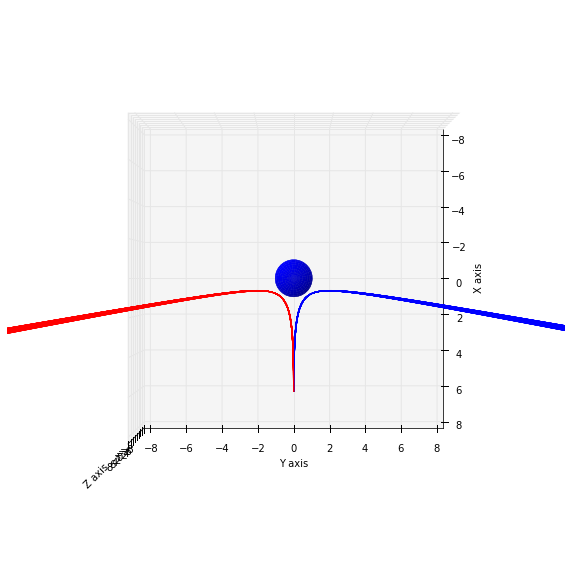

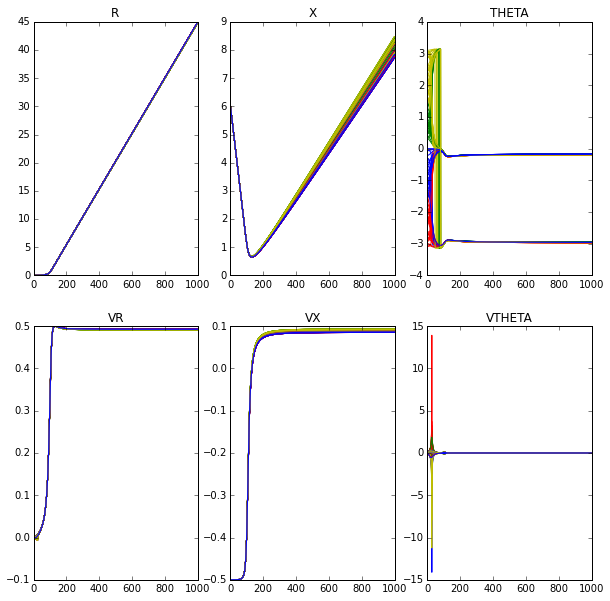

In [86]:
crea(theta_0 = (23./180.)*pi, phi_0 = (180./180.)*pi, T_max = 100, Ts = 1000, Num = 100, r_max = 0.01, 
     vx = -0.5, vy = 0., vz = 0., F1=1, F2=1, q0 = 0.)

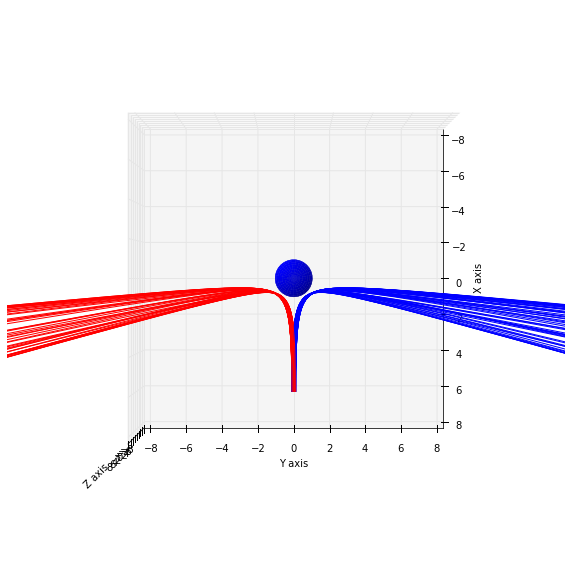

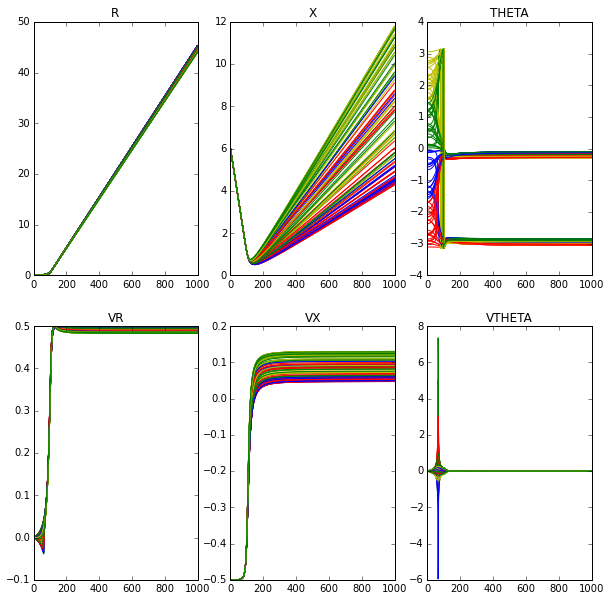

In [87]:
crea(theta_0 = (23./180.)*pi, phi_0 = (180./180.)*pi, T_max = 100, Ts = 1000, Num = 100, r_max = 0.1, 
     vx = -0.5, vy = 0., vz = 0., F1=1, F2=1, q0 = 0.)

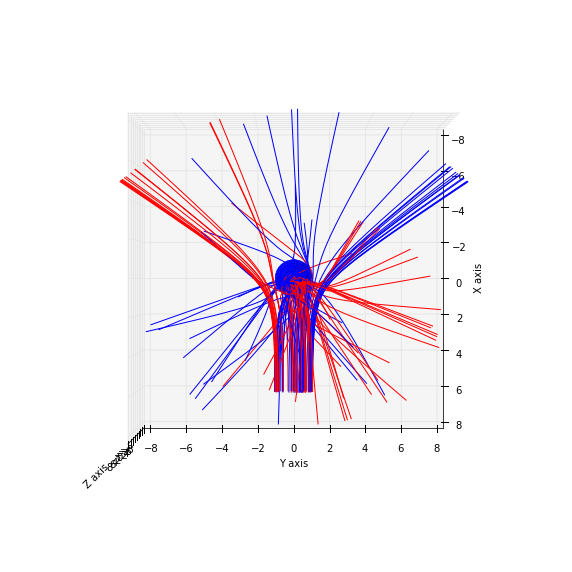

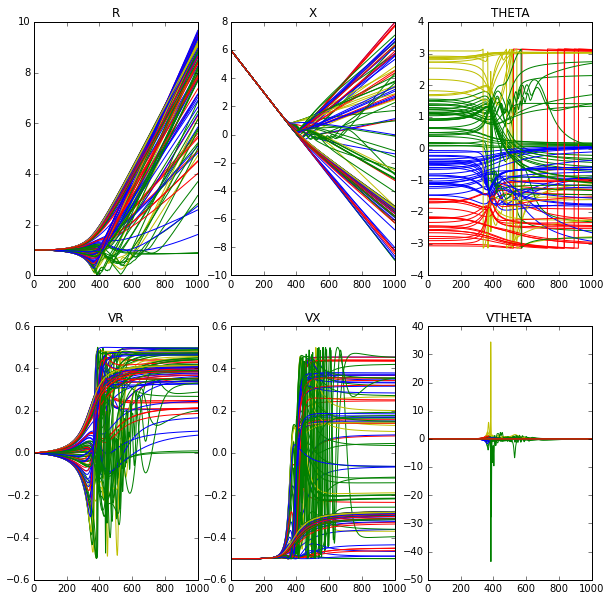

In [92]:
crea(theta_0 = (23./180.)*pi, phi_0 = (180./180.)*pi, T_max = 30, Ts = 1000, Num = 100, r_max = 1., 
     vx = -0.5, vy = 0., vz = 0., F1=1, F2=1, q0 = 0.)